# Imports

In [2]:
import sys
sys.path.append("..")
sys.path.append(".")

from pathlib import Path
import os
import shutil
import pickle 

# 3rd party
import pandas as pd
import numpy as np
import copy
import json
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import multiprocessing
import matplotlib.pyplot as plt
from scipy import stats

# Local
from src.data import process

midst_dir = '/data8/projets/dev_synthetic_data/code/lherbault/MIDSTModels'
sys.path.append(midst_dir)

clover_dir = '/data8/projets/dev_synthetic_data/code/lherbault/git_dev_synthetic_data'
sys.path.append(clover_dir)

from metrics.utility.population import Distinguishability

from src.externals.MIDSTModels.midst_models.single_table_TabDDPM.complex_pipeline import (
    clava_clustering,
    clava_training,
    clava_fine_tuning,
    clava_load_pretrained,
    clava_synthesizing,
    load_configs,
    CustomUnpickler
)
from midst_models.single_table_TabDDPM.pipeline_modules import load_multi_table

ModuleNotFoundError: No module named 'faiss'

In [2]:
from pymoo.algorithms.soo.nonconvex.ga import GA, comp_by_cv_and_fitness
from pymoo.factory import get_problem, get_termination
from pymoo.optimize import minimize
from pymoo.core.problem import ElementwiseProblem, StarmapParallelization
from pymoo.core.population import Population
from pymoo.core.individual import Individual
from pymoo.core.evaluator import Evaluator
from multiprocessing.pool import ThreadPool
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.selection.tournament import TournamentSelection

In [3]:
data_dir = "/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1"

# Data processing

We want to test our attack idea. For that we need to produce 3 different training sets:
- tabddpm_1 without all challenge observations
- tabddpm_1 with only the challenge observations that were in the original training set
- tabddpm_1 with only the challenge observations that were NOT in the original training set

We will also produce similar training sets, limiting the observations in the first tabddpm_1 to 900, and then 100.

In [4]:
train_original = pd.read_csv(os.path.join(data_dir, 'train_with_id.csv'))
challenge = pd.read_csv(os.path.join(data_dir, 'challenge_with_id.csv'))
challenge_labels = pd.read_csv(os.path.join(data_dir, 'challenge_label.csv'))

In [5]:
# Training sets with full length
train_wo = train_original[~train_original['trans_id'].isin(challenge['trans_id'])].copy()

In [6]:
train_with_targets = train_original.copy()
train_with_traps = pd.concat([train_wo, challenge[challenge_labels['is_train']==0]], axis=0).copy()

# Training sets with len(train_wo)=900
train_wo_s = train_wo.sample(n=900, random_state=14).copy()
train_with_targets_s = pd.concat([train_wo_s, challenge[challenge_labels['is_train']==1]], axis=0).copy()
train_with_traps_s = pd.concat([train_wo_s, challenge[challenge_labels['is_train']==0]], axis=0).copy()

# Training sets with len(train_wo)=100
train_wo_xs = train_wo.sample(n=100, random_state=14).copy()
train_with_targets_xs = pd.concat([train_wo_xs, challenge[challenge_labels['is_train']==1]], axis=0).copy()
train_with_traps_xs = pd.concat([train_wo_xs, challenge[challenge_labels['is_train']==0]], axis=0).copy()

# Create the necessary folders and config files

In [6]:
base_path = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack'
json_file_path = '/data8/projets/dev_synthetic_data/code/lherbault/github_ensemble_mia/configs/trans.json'

In [ ]:
for string, tset in {
             'train_wo': train_wo, 
             'train_with_targets': train_with_targets, 
             'train_with_traps': train_with_traps,
             'train_wo_s': train_wo_s, 
             'train_with_targets_s': train_with_targets_s, 
             'train_with_traps_s': train_with_traps_s,
             'train_wo_xs': train_wo_xs, 
             'train_with_targets_xs': train_with_targets_xs, 
             'train_with_traps_xs': train_with_traps_xs
    }.items():
    new_folder = os.path.join(base_path, string)

    # create the new folder if it doesn't exist
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    # save the training data
    tset.to_csv(os.path.join(new_folder, 'train.csv'), index=False)

    # copy the original config file to the new folder
    shutil.copy(json_file_path, new_folder)
    new_json_file_path = os.path.join(new_folder, 'trans.json')

    # modify the config file to give the correct training data and saving directory
    with open(new_json_file_path, "r") as file:
        data = json.load(file)
    data['general']['data_dir'] = new_folder
    data['general']['exp_name'] = string
    data['general']['workspace_dir'] = os.path.join(base_path, 'workspace')

    # modify the model parameters for smaller sets
    if string[-2:]=='_s' or string[-3:]=='_xs':
        data['diffusion']['d_layers'] = [32, 64, 64, 64, 64, 32]
        data['diffusion']['iterations'] = 10000
        data['classifier']['d_layers'] = [16, 32, 64, 128, 64, 32, 16]
        data['classifier']['dim_t'] = 16
        data['classifier']['iterations'] = 1000

    # save the changed to the new json file
    with open(new_json_file_path, "w") as file:
        json.dump(data, file, indent=4)

    print("Changes made successfully in folder ", new_folder)    

# Train all tabDDPM models

In [7]:
material = {
    'tables': {},
    'relation_order': {},
    'save_dir': {},
    'all_group_lengths_prob_dicts': {},
    'models': {},
    'configs': {},
    'synth_data': {},
    'distinguishability': {}}

In [ ]:
for tset in ['train_wo', 'train_with_targets', 'train_with_traps',
             'train_wo_s', 'train_with_targets_s', 'train_with_traps_s',
             'train_wo_xs', 'train_with_targets_xs', 'train_with_traps_xs']:

    # Set up the config
    folder = os.path.join(base_path, tset)
    configs, save_dir = load_configs(os.path.join(folder, 'trans.json'))

    material['configs'][tset] = configs
    material['save_dir'][tset] = save_dir

    # Load tables
    tables, relation_order, dataset_meta = load_multi_table(configs["general"]["data_dir"])
    material['relation_order'][tset] = relation_order

    # Clustering on the multi-table dataset
    tables, all_group_lengths_prob_dicts = clava_clustering(
        tables, relation_order, save_dir, configs
    )
    material['tables'][tset] = tables
    material['all_group_lengths_prob_dicts'][tset] = all_group_lengths_prob_dicts

    # Train models
    models = clava_training(tables, relation_order, save_dir, configs)
    material['models'][tset] = models

    # Determine the sample scale
    # We want the final synthetic data = len(provided_synth_data) = 20,000
    sample_scale = 20000/len(tables['trans']['df'])

    # Generate synthetic data from scratch
    cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
        tables,
        relation_order,
        save_dir,
        all_group_lengths_prob_dicts,
        models,
        configs,
        sample_scale=sample_scale,
        )

    material['synth_data'][tset] = cleaned_tables['trans']

# Compute the distinguishability of all freshly generated data vs. provided synthetic data

In [212]:
synth_data = pd.read_csv(os.path.join(base_path, 'trans_synthetic.csv'))

synth_train, synth_test = train_test_split(synth_data, test_size=0.3, random_state=42)

In [9]:
metadata = {
    "continuous": ["trans_date", "amount", "balance", "bank"],
    "categorical": ["trans_type", "operation", "k_symbol", "account"],
    "variable_to_predict": "trans_type",
}

In [108]:
list(synth_data.columns)

['trans_date',
 'trans_type',
 'operation',
 'amount',
 'balance',
 'k_symbol',
 'bank',
 'account']

In [235]:
for tset in ['train_wo', 'train_with_targets', 'train_with_traps',
             'train_wo_s', 'train_with_targets_s', 'train_with_traps_s',
             'train_wo_xs', 'train_with_targets_xs', 'train_with_traps_xs']:

    print(tset)
    
    temp_train, temp_test = train_test_split(material['synth_data'][tset][list(synth_data.columns)].astype(synth_data.dtypes.to_dict()),
                                             test_size=0.3, random_state=42)
    
    material['distinguishability'][tset] = Distinguishability().compute(
        df_real={'train': synth_train, 'test': synth_test},
        df_synthetic={'train': temp_train, 'test': temp_test},
        metadata=metadata,
        optimize_xgb=False
    )

train_wo
train_with_targets
train_with_traps
train_wo_s
train_with_targets_s
train_with_traps_s
train_wo_xs
train_with_targets_xs
train_with_traps_xs


In [120]:
# Save distinguishability as it was super long to run
part_dict_2 = {'original_synth_train': synth_train, 
             'original_synth_test': synth_test,
             'other_synth_data': material['synth_data'],
             'distinguishability': material['distinguishability']}

with open(os.path.join(base_path, 'synth_data_dict_2.pkl'), 'wb') as file:
    pickle.dump(part_dict_2, file)

# Compare distinguishability for all sets

In [125]:
tset_list = ['train_wo', 'train_with_targets', 'train_with_traps',
             'train_wo_s', 'train_with_targets_s', 'train_with_traps_s',
             'train_wo_xs', 'train_with_targets_xs', 'train_with_traps_xs']

In [236]:
pd.DataFrame({tset: material['distinguishability'][tset]['average'] 
              for tset in ['train_wo', 'train_with_targets', 'train_with_traps']})

,train_wo,train_with_targets,train_with_traps
propensity_mse,0.009670,0.008447,0.007644
prediction_mse_real,0.009595,0.008498,0.007719
prediction_mse_synth,0.009745,0.008396,0.007569
prediction_auc_rescaled,0.043739,0.009333,0.054753
prediction_mse,0.005161,0.004152,0.004166


In [237]:
pd.DataFrame({tset: material['distinguishability'][tset]['average'] 
              for tset in ['train_wo_s', 'train_with_targets_s', 'train_with_traps_s']})

,train_wo_s,train_with_targets_s,train_with_traps_s
propensity_mse,0.236830,0.209051,0.279447
prediction_mse_real,0.144025,0.144240,0.180410
prediction_mse_synth,0.329634,0.273863,0.378483
prediction_auc_rescaled,0.638910,0.666148,0.717327
prediction_mse,0.223014,0.197152,0.263401


In [238]:
pd.DataFrame({tset: material['distinguishability'][tset]['average'] 
              for tset in ['train_wo_xs', 'train_with_targets_xs', 'train_with_traps_xs']})

,train_wo_xs,train_with_targets_xs,train_with_traps_xs
propensity_mse,0.413087,0.239378,0.236189
prediction_mse_real,0.310126,0.210041,0.191830
prediction_mse_synth,0.516049,0.268716,0.280549
prediction_auc_rescaled,0.846837,0.659184,0.698354
prediction_mse,0.400290,0.222220,0.220978


# Next steps
1. Refaire la meme experience en ne prenant pas le training set de depart mais plutot un subset au hasard parmi la population entiere (retirer toutes les donnees challenge, rajouter targets puis traps, et un mix des deux).
2. Si c'est concluant, choisir un algorithme (genetique?) pour la selection du vecteur binaire de selection des observations dans le set challenge.

In [10]:
pop_dir = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/population/50000_rows_real_train/'

In [11]:
train_original = pd.read_csv(os.path.join(pop_dir, 'real_train.csv'))
challenge = pd.read_csv(os.path.join(data_dir, 'challenge_with_id.csv'))
challenge_labels = pd.read_csv(os.path.join(data_dir, 'challenge_label.csv'))

# Training set with full length
train_wo = train_original[~train_original['trans_id'].isin(challenge['trans_id'])].copy()

In [17]:
# Training sets with len(train_wo)=100
train_wo_xs = train_wo.sample(n=400, random_state=16).copy()
train_with_targets_xs = pd.concat([train_wo_xs, challenge[challenge_labels['is_train']==1]], axis=0).copy()
train_with_traps_xs = pd.concat([train_wo_xs, challenge[challenge_labels['is_train']==0]], axis=0).copy()
train_with_both_xs = pd.concat([train_wo_xs,
                                challenge[challenge_labels['is_train']==1].sample(n=50, random_state=14),
                                challenge[challenge_labels['is_train']==0].sample(n=50, random_state=14)],
                               axis=0)

In [18]:
for string, tset in {
             'train_pop_with_targets_xs': train_with_targets_xs, 
             'train_pop_with_traps_xs': train_with_traps_xs,
             'train_pop_with_both_xs': train_with_both_xs,
    }.items():
    new_folder = os.path.join(base_path, string)

    # create the new folder if it doesn't exist
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)

    # save the training data
    tset.to_csv(os.path.join(new_folder, 'train.csv'), index=False)

    # copy the original config file to the new folder
    shutil.copy(json_file_path, new_folder)
    new_json_file_path = os.path.join(new_folder, 'trans.json')

    # modify the config file to give the correct training data and saving directory
    with open(new_json_file_path, "r") as file:
        data = json.load(file)
    data['general']['data_dir'] = new_folder
    data['general']['exp_name'] = string
    data['general']['workspace_dir'] = os.path.join(base_path, 'workspace')

    # modify the model parameters for smaller sets
    if string[-2:]=='_s' or string[-3:]=='_xs':
        data['diffusion']['d_layers'] = [32, 64, 64, 64, 64, 32]
        data['diffusion']['iterations'] = 10000
        data['classifier']['d_layers'] = [16, 32, 64, 128, 64, 32, 16]
        data['classifier']['dim_t'] = 16
        data['classifier']['iterations'] = 1000

    # save the changed to the new json file
    with open(new_json_file_path, "w") as file:
        json.dump(data, file, indent=4)

    print("Changes made successfully in folder ", new_folder)    

Changes made successfully in folder  /data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/train_pop_with_targets_xs
Changes made successfully in folder  /data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/train_pop_with_traps_xs
Changes made successfully in folder  /data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/train_pop_with_both_xs


In [19]:
for tset in ['train_pop_with_targets_xs', 
             'train_pop_with_traps_xs',
             'train_pop_with_both_xs']:

    # Set up the config
    folder = os.path.join(base_path, tset)
    configs, save_dir = load_configs(os.path.join(folder, 'trans.json'))

    material['configs'][tset] = configs
    material['save_dir'][tset] = save_dir

    # Load tables
    tables, relation_order, dataset_meta = load_multi_table(configs["general"]["data_dir"])
    material['relation_order'][tset] = relation_order

    # Clustering on the multi-table dataset
    tables, all_group_lengths_prob_dicts = clava_clustering(
        tables, relation_order, save_dir, configs
    )
    material['tables'][tset] = tables
    material['all_group_lengths_prob_dicts'][tset] = all_group_lengths_prob_dicts

    # Train models
    models = clava_training(tables, relation_order, save_dir, configs)
    material['models'][tset] = models

    # Determine the sample scale
    # We want the final synthetic data = len(provided_synth_data) = 20,000
    sample_scale = 20000/len(tables['trans']['df'])

    # Generate synthetic data from scratch
    cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
        tables,
        relation_order,
        save_dir,
        all_group_lengths_prob_dicts,
        models,
        configs,
        sample_scale=sample_scale,
        )

    material['synth_data'][tset] = cleaned_tables['trans']

Table name: trans, Total dataframe shape: (500, 8), Numerical data shape: (500, 4), Categorical data shape: (500, 4)
Clustering checkpoint found, loading...
Training None -> trans model from scratch
Model params: {'num_classes': 0, 'is_y_cond': 'none', 'rtdl_params': {'d_layers': [32, 64, 64, 64, 64, 32], 'dropout': 0.0}, 'd_in': 8}
mlp
Step 500/10000 MLoss: 0.0 GLoss: 0.5356 Sum: 0.5356
Step 1000/10000 MLoss: 0.0 GLoss: 0.4394 Sum: 0.4394
Step 1500/10000 MLoss: 0.0 GLoss: 0.3945 Sum: 0.3945
Step 2000/10000 MLoss: 0.0 GLoss: 0.3491 Sum: 0.3491
Step 2500/10000 MLoss: 0.0 GLoss: 0.3277 Sum: 0.3277
Step 3000/10000 MLoss: 0.0 GLoss: 0.311 Sum: 0.311
Step 3500/10000 MLoss: 0.0 GLoss: 0.3 Sum: 0.3
Step 4000/10000 MLoss: 0.0 GLoss: 0.295 Sum: 0.295
Step 4500/10000 MLoss: 0.0 GLoss: 0.2901 Sum: 0.2901
Step 5000/10000 MLoss: 0.0 GLoss: 0.2843 Sum: 0.2843
Step 5500/10000 MLoss: 0.0 GLoss: 0.2776 Sum: 0.2776
Step 6000/10000 MLoss: 0.0 GLoss: 0.2754 Sum: 0.2754
Step 6500/10000 MLoss: 0.0 GLoss: 0.

In [20]:
dist = Distinguishability(use_gpu=True)

for tset in ['train_pop_with_targets_xs', 
             'train_pop_with_traps_xs',
             'train_pop_with_both_xs']:

    print(tset)
    
    temp_train, temp_test = train_test_split(material['synth_data'][tset][list(synth_data.columns)].astype(synth_data.dtypes.to_dict()),
                                             test_size=0.3, random_state=42)
    
    material['distinguishability'][tset] = dist.compute(
        df_real={'train': synth_train, 'test': synth_test},
        df_synthetic={'train': temp_train, 'test': temp_test},
        metadata=metadata,
        optimize_xgb=False
    )

train_pop_with_targets_xs
train_pop_with_traps_xs
train_pop_with_both_xs


In [21]:
pd.DataFrame({tset: material['distinguishability'][tset]['average']
              for tset in [ 
             'train_pop_with_targets_xs', 
             'train_pop_with_traps_xs',
             'train_pop_with_both_xs']})

,train_pop_with_targets_xs,train_pop_with_traps_xs,train_pop_with_both_xs
propensity_mse,0.368401,0.305286,0.372941
prediction_mse_real,0.285220,0.242248,0.316865
prediction_mse_synth,0.451582,0.368324,0.429016
prediction_auc_rescaled,0.760666,0.729310,0.772150
prediction_mse,0.348458,0.285901,0.350656


# Code structure for actual attack

pop_train = all training population excluding the challenge points

for n_reps:
- pick out a random slice of pop_train with n_train = 100
- optimize a binary vector for the inclusion of the challenge points
  - training set = slice of pop_train + included challenge_points
  - tabddpm is trained on the training set
  - distinguishability(generated 20k; provided 20k) is the lowest
- store the random slice, the best binary vector, the final distinguishability scores

at the end:
- compute the average of all the binary vectors to get the probability of inclusion
- compute the tpr_at_fpr_0.1

In [12]:
def config_tabddpm(
    data_dir='/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir'
):
    # modify the config file to give the correct training data and saving directory
    temp_json_file_path = os.path.join(data_dir, 'trans.json')
    with open(temp_json_file_path, "r") as file:
        data = json.load(file)
    data['general']['data_dir'] = data_dir
    data['general']['exp_name'] = 'tmp'
    data['general']['workspace_dir'] = os.path.join(data_dir, 'tmp_workspace')

    # modify the model parameters for smaller sets
    data['diffusion']['d_layers'] = [32, 64, 64, 64, 64, 32]
    data['diffusion']['iterations'] = 10000
    data['classifier']['d_layers'] = [16, 32, 64, 128, 64, 32, 16]
    data['classifier']['dim_t'] = 16
    data['classifier']['iterations'] = 1000

    # save the changed to the new json file
    with open(temp_json_file_path, "w") as file:
        json.dump(data, file, indent=4)

    print("Changes made successfully in path ", temp_json_file_path)  

    # Set up the config
    configs, save_dir = load_configs(temp_json_file_path)

    return configs, save_dir
    

In [13]:
def train_tabddpm(
    train_set,
    configs,
    save_dir,
    data_dir='/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir',
):
    material = {
    'tables': {},
    'relation_order': {},
    'save_dir': {},
    'all_group_lengths_prob_dicts': {},
    'models': {},
    'configs': {},
    'synth_data': {}}

    material['configs'] = configs
    material['save_dir'] = save_dir

    # Load tables
    tables, relation_order, dataset_meta = load_multi_table(configs["general"]["data_dir"], train_df=train_set)
    material['relation_order'] = relation_order

    # Clustering on the multi-table dataset
    tables, all_group_lengths_prob_dicts = clava_clustering(
        tables, relation_order, save_dir, configs
    )
    material['tables'] = tables
    material['all_group_lengths_prob_dicts'] = all_group_lengths_prob_dicts

    # Train models
    models = clava_training(tables, relation_order, save_dir, configs)
    material['models'] = models

    # Determine the sample scale
    # We want the final synthetic data = len(provided_synth_data) = 20,000
    sample_scale = 20000/len(tables['trans']['df'])

    # Generate synthetic data from scratch
    cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
        tables,
        relation_order,
        save_dir,
        all_group_lengths_prob_dicts,
        models,
        configs,
        sample_scale=sample_scale,
        )

    material['synth_data'] = cleaned_tables['trans']

    return material

In [14]:
def fine_tune_tabddpm(
    trained_models,
    new_train_set,
    configs,
    save_dir,
    new_diffusion_iterations = 100, 
    new_classifier_iterations = 10,
    data_dir='/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir',
):
    material = {
    'tables': {},
    'relation_order': {},
    'save_dir': {},
    'all_group_lengths_prob_dicts': {},
    'models': {},
    'configs': {},
    'synth_data': {}}

    material['configs'] = configs
    material['save_dir'] = save_dir

    # Load tables
    new_tables, relation_order, dataset_meta = load_multi_table(configs["general"]["data_dir"], train_df=new_train_set)
    material['relation_order'] = relation_order

    # Clustering on the multi-table dataset
    new_tables, all_group_lengths_prob_dicts = clava_clustering(
        new_tables, relation_order, save_dir, configs
    )
    material['tables'] = new_tables
    material['all_group_lengths_prob_dicts'] = all_group_lengths_prob_dicts

    # Train models
    copied_models = copy.deepcopy(trained_models)
    new_models = clava_fine_tuning(copied_models, new_tables, relation_order, save_dir, configs, 
                                   new_diffusion_iterations, new_classifier_iterations)
    material['new_models'] = new_models

    # Determine the sample scale
    # We want the final synthetic data = len(provided_synth_data) = 20,000
    sample_scale = 20000/len(new_tables['trans']['df'])

    # Generate synthetic data from scratch
    cleaned_tables, synthesizing_time_spent, matching_time_spent = clava_synthesizing(
        new_tables,
        relation_order,
        save_dir,
        all_group_lengths_prob_dicts,
        new_models,
        configs,
        sample_scale=sample_scale,
        )

    material['synth_data'] = cleaned_tables['trans']

    return material

In [15]:
def evaluate_subset(
    generated_data,
    provided_data,
    metadata):

    synth_train, synth_test = train_test_split(provided_data, test_size=0.3, random_state=42)
    temp_train, temp_test = train_test_split(generated_data[list(provided_data.columns)].astype(provided_data.dtypes.to_dict()),
                                             test_size=0.3, random_state=42)

    dist = Distinguishability(use_gpu=True)
    
    temp_distinguishability = dist.compute(
        df_real={'train': synth_train, 'test': synth_test},
        df_synthetic={'train': temp_train, 'test': temp_test},
        metadata=metadata,
        optimize_xgb=False
    )

    return temp_distinguishability['average']['prediction_auc_rescaled']

In [16]:
class SubsetProblem(ElementwiseProblem):
    def __init__(self, train, challenge_df, ref_synth_data, metadata, n_selected, configs, save_dir, n_threads=4):
        # train: DataFrame of the training data
        # L: DataFrame of the challenge observations
        # n_challenge: Number of challenge observations to be selected
        self.train = train
        self.challenge_df = challenge_df
        self.n_selected = n_selected
        self.ref_synth_data = ref_synth_data
        self.metadata = metadata
        n_var = len(challenge_df)  # Number of decision variables (one per challenge observation)
        xl = np.zeros(n_var)  # 0 means no selection
        xu = np.ones(n_var)  # 1 means select the challenge observation

        # initialize the thread pool and create the runner
        pool = ThreadPool(n_threads)
        runner = StarmapParallelization(pool.starmap)
        
        super().__init__(n_var=n_var, n_obj=1, n_constr=0, xl=xl, xu=xu, elementwise_runner = runner)

    def _evaluate(self, x, out, *args, **kwargs):
        # Select observations from L based on x
        selected_indices = np.where(x == 1)[0]
        selected_challenges = self.challenge_df.iloc[selected_indices]

        if len(selected_challenges) != self.n_selected:
            out["F"] = np.inf  # Penalize if subset size is not 100
        else:
            # Concatenate train data with selected challenges
            augmented_train = pd.concat([self.train, selected_challenges], axis=0, ignore_index=True)
    
            # Train the model on the augmented training set
            train_result = train_tabddpm(augmented_train, configs, save_dir)
    
            # Compute the objective function
            out["F"] = evaluate_subset(generated_data=train_result['synth_data'],
                                       provided_data=self.ref_synth_data,
                                       metadata=self.metadata)

In [17]:
class FineSubsetProblem(ElementwiseProblem):
    def __init__(self, train, challenge_df, ref_synth_data, metadata, n_selected, configs, save_dir, n_threads=4):
        # train: DataFrame of the training data
        # L: DataFrame of the challenge observations
        # n_challenge: Number of challenge observations to be selected
        
        self.train = train
        self.challenge_df = challenge_df
        self.n_selected = n_selected
        self.ref_synth_data = ref_synth_data
        self.metadata = metadata
        n_var = len(challenge_df)  # Number of decision variables (one per challenge observation)
        xl = np.zeros(n_var)  # 0 means no selection
        xu = np.ones(n_var)  # 1 means select the challenge observation

        # initialize the thread pool and create the runner
        pool = ThreadPool(n_threads)
        runner = StarmapParallelization(pool.starmap)

        # initialize the model with the given population
        self.initial_model = train_tabddpm(train, configs, save_dir)['models']
        
        super().__init__(n_var=n_var, n_obj=1, n_constr=0, xl=xl, xu=xu, elementwise_runner = runner)

    def _evaluate(self, x, out, *args, **kwargs):
        # Select observations from L based on x
        selected_indices = np.where(x == 1)[0]
        selected_challenges = self.challenge_df.iloc[selected_indices]

        if len(selected_challenges) != self.n_selected:
            out["F"] = np.inf  # Penalize if subset size is not 100
        else:
            # Train the model on the augmented training set
            train_result = fine_tune_tabddpm(trained_models=self.initial_model,
                                             new_train_set=selected_challenges,
                                             configs=configs,
                                             save_dir=save_dir,
                                             new_diffusion_iterations = 2500, 
                                             new_classifier_iterations = 250,
                                            )
    
            # Compute the objective function
            out["F"] = evaluate_subset(generated_data=train_result['synth_data'],
                                       provided_data=self.ref_synth_data,
                                       metadata=self.metadata)

In [18]:
optim_results = {'X': [],
                 'dist_auc': []}

In [19]:
challenge_points = challenge
train_pop = train_wo
n_reps = 1

n_challenges = len(challenge_points)
n_selected = 100
n_pop_init = 50

In [20]:
configs, save_dir = config_tabddpm(
    data_dir='/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir'
)

Changes made successfully in path  /data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir/trans.json


# Code to retrain the whole thing every time we have a new solution

In [18]:
for _ in range(n_reps):
    # pick out a random slice of pop_train with n_train = 400
    train = train_pop.sample(n=400)
    
    # optimize a binary vector for the inclusion of the challenge points
    problem = SubsetProblem(train = train,
                            challenge_df = challenge_points,
                            n_selected = n_selected,
                            ref_synth_data = synth_data,
                            metadata = metadata,
                            configs=configs,
                            save_dir=save_dir)

    # Create the initial data
    x_zeros = np.zeros((n_pop_init, n_challenges-n_selected))
    x_ones = np.ones((n_pop_init, n_selected))
    x = np.concatenate((x_zeros, x_ones), axis=1)
    for i in range(x.shape[0]):
        np.random.shuffle(x[i])
    pop = Population.new("X", x)

    Evaluator().eval(problem, pop)#, elementwise_runner=runner)
    
    # Define the genetic algorithm
    algorithm = GA(
        pop_size=100,
        eliminate_duplicates=True,
        sampling=pop,
    )
    
    # Define the termination criterion
    termination = get_termination("n_gen", 250)

    # Perform the optimization
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    # Output the best solution found
    print("Best solution: ", res.X)
    optim_results['X'].append(res.X)
    print("Best objective value: ", res.F)
    optim_results['dist_auc'].append(res.F)

NameError: name 'n_reps' is not defined

to do : 
- get the config part out of the train function
- change ddpm code to stop reading the train.csv file - take it as given here

In [26]:
from sklearn.metrics import confusion_matrix

In [31]:
confusion_matrix(challenge_labels, np.round(optim_results['X'][0]))

array([[54, 46],
       [46, 54]])

In [27]:
conf_df = pd.concat([challenge_labels, pd.Series(np.round(optim_results['X'][0]))], axis=1)

In [28]:
conf_df.to_csv('optim_results.csv')

In [34]:
# Pickle dump the result
with open('pymoo_result.pkl', 'wb') as f:
    pickle.dump(res, f)

# Code to only finetune the model

### Do it for each of the 200 observations (maybe a greedy version is enough)

In [23]:
n_reps = 1

In [22]:
master_dist_results = []

for rep in range(n_reps):
    print('Starting on random slice number ', rep)
    # pick out a random slice of pop_train with n_train = 400
    initial_train = train_pop.sample(n=400)

    # Train the model on this initial training set
    initial_result = train_tabddpm(initial_train, configs, save_dir)
    final_columns = [col for col in initial_result['synth_data'].columns if '_id' not in col]

    # Initialize the distinguishability results
    dist_results = []

    for i in challenge_points.index:
        print('Evaluating challenge point number ', i)
        # Finetune the model with this new_data
        new_result = fine_tune_tabddpm(
                        trained_models=initial_result['models'],
                        new_train_set=challenge_points.iloc[[i]],
                        configs=configs,
                        save_dir=save_dir,
                        new_diffusion_iterations = 100, 
                        new_classifier_iterations = 10,
                        data_dir='/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/temp_dir',
                    )
        # Compute the objective function
        dist_auc = evaluate_subset(generated_data=new_result['synth_data'][final_columns],
                                   provided_data=synth_data[final_columns],
                                   metadata=metadata)
        dist_results.append(dist_auc)
        print('AUC of point number ', i, ' = ', dist_auc)
    
    master_dist_results.append(dist_results)

Starting on random slice number  0
Table name: trans, Total dataframe shape: (400, 8), Numerical data shape: (400, 4), Categorical data shape: (400, 4)
Clustering checkpoint found, loading...
Training None -> trans model from scratch
Model params: {'num_classes': 0, 'is_y_cond': 'none', 'rtdl_params': {'d_layers': [32, 64, 64, 64, 64, 32], 'dropout': 0.0}, 'd_in': 8}
mlp
Step 500/10000 MLoss: 0.0 GLoss: 0.4949 Sum: 0.4949
Step 1000/10000 MLoss: 0.0 GLoss: 0.4132 Sum: 0.4132
Step 1500/10000 MLoss: 0.0 GLoss: 0.3489 Sum: 0.3489
Step 2000/10000 MLoss: 0.0 GLoss: 0.3123 Sum: 0.3123
Step 2500/10000 MLoss: 0.0 GLoss: 0.3012 Sum: 0.3012
Step 3000/10000 MLoss: 0.0 GLoss: 0.2929 Sum: 0.2929
Step 3500/10000 MLoss: 0.0 GLoss: 0.2885 Sum: 0.2885
Step 4000/10000 MLoss: 0.0 GLoss: 0.2845 Sum: 0.2845
Step 4500/10000 MLoss: 0.0 GLoss: 0.2773 Sum: 0.2773
Step 5000/10000 MLoss: 0.0 GLoss: 0.277 Sum: 0.277
Step 5500/10000 MLoss: 0.0 GLoss: 0.2768 Sum: 0.2768
Step 6000/10000 MLoss: 0.0 GLoss: 0.2738 Sum: 

In [23]:
dist_results

[0.8547082527777778,
 0.8421981722222223,
 0.8255688694444444,
 0.8136444805555556,
 0.8564126805555556,
 0.8347500888888888,
 0.8331871027777777,
 0.8749438805555556,
 0.8076010861111111,
 0.8170259916666666,
 0.8436717777777778,
 0.8503717638888888,
 0.8356802583333334,
 0.8314477166666666,
 0.8419398166666664,
 0.837362875,
 0.8220970361111111,
 0.8495920972222223,
 0.8522501833333334,
 0.8412599638888889,
 0.8160522611111112,
 0.8282693805555554,
 0.8309256805555554,
 0.8310658722222224,
 0.8172244,
 0.8140687111111111,
 0.8409317222222222,
 0.8172015888888888,
 0.8259076999999999,
 0.8538980305555557,
 0.8461848277777776,
 0.8349992527777779,
 0.8369098249999999,
 0.813833547222222,
 0.8323884500000001,
 0.8597206888888888,
 0.8286155416666665,
 0.8333039027777778,
 0.8433493222222221,
 0.84534155,
 0.8498884916666665,
 0.8363242861111113,
 0.8663963722222222,
 0.8551421138888887,
 0.8060821611111113,
 0.8132033111111111,
 0.8243582722222221,
 0.8348363388888889,
 0.85629498611111

In [24]:
challenge_test = challenge_points.copy()
challenge_test['auc'] = dist_results

In [27]:
challenge_test

,trans_id,account_id,trans_date,trans_type,operation,amount,balance,k_symbol,bank,account,auc,pred,truth
0,1134831,3878,1529,2,1,1648.0,13237.2,0,13,38488340,0.854708,0,1
1,3576816,1412,272,0,0,152.2,36926.6,7,0,0,0.842198,0,1
2,583865,1987,750,2,4,2400.0,35598.1,1,0,0,0.825569,0,1
3,895287,3051,1382,2,1,4104.0,65575.1,5,12,89318686,0.813644,0,0
4,1501078,5118,1239,2,4,800.0,27560.7,1,0,0,0.856413,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,669747,2285,1580,2,4,14.6,20441.4,6,0,0,0.799496,0,0
196,453622,1540,1987,2,4,2500.0,80540.9,1,0,0,0.815839,0,0
197,918970,3132,2060,2,4,2400.0,23541.3,1,0,0,0.827752,0,1
198,265153,905,2015,2,1,53.0,21380.3,3,6,13783419,0.870562,0,0


In [28]:
lowest_100_indices = challenge_test.nsmallest(100, 'auc').index
challenge_test['pred'] = 0
challenge_test.loc[lowest_100_indices, 'pred'] = 1
challenge_test['truth'] = challenge_labels

In [30]:
len(challenge_test[challenge_test['truth']==challenge_test['pred']])

86

# Code with problem optimization and fine-tuning

In [21]:
challenge_points = challenge
train_pop = train_wo
n_reps = 1

n_challenges = len(challenge_points)
n_selected = 100
n_pop_init = 40

In [ ]:
for _ in range(n_reps):
    # pick out a random slice of pop_train with n_train = 400
    train = train_pop.sample(n=400)
    
    # optimize a binary vector for the inclusion of the challenge points
    problem = FineSubsetProblem(train = train,
                            challenge_df = challenge_points,
                            n_selected = n_selected,
                            ref_synth_data = synth_data,
                            metadata = metadata,
                            configs=configs,
                            save_dir=save_dir,
                            n_threads=4)

    # Create the initial data
    x_zeros = np.zeros((n_pop_init, n_challenges-n_selected))
    x_ones = np.ones((n_pop_init, n_selected))
    x = np.concatenate((x_zeros, x_ones), axis=1)
    for i in range(x.shape[0]):
        np.random.shuffle(x[i])
    pop = Population.new("X", x)

    Evaluator().eval(problem, pop)
    
    # Define the genetic algorithm
    algorithm = GA(
        pop_size=40,
        n_offsprings=40-2,
        selection=TournamentSelection(pressure=2, func_comp=comp_by_cv_and_fitness),
        #survival="elitist",
        crossover=SBX(prob=0.9, eta=15),
        eliminate_duplicates=True,
        sampling=pop,
    )
    
    # Define the termination criterion
    termination = get_termination("n_gen", 150)

    # Perform the optimization
    res = minimize(problem,
                   algorithm,
                   termination,
                   seed=1,
                   save_history=True,
                   verbose=True)

    # Output the best solution found
    print("Best solution: ", res.X)
    optim_results['X'].append(res.X)
    print("Best objective value: ", res.F)
    optim_results['dist_auc'].append(res.F)

Table name: trans, Total dataframe shape: (400, 8), Numerical data shape: (400, 4), Categorical data shape: (400, 4)
Clustering checkpoint found, loading...
Training None -> trans model from scratch
Model params: {'num_classes': 0, 'is_y_cond': 'none', 'rtdl_params': {'d_layers': [32, 64, 64, 64, 64, 32], 'dropout': 0.0}, 'd_in': 8}
mlp
Step 500/10000 MLoss: 0.0 GLoss: 0.5042 Sum: 0.5042
Step 1000/10000 MLoss: 0.0 GLoss: 0.379 Sum: 0.379
Step 1500/10000 MLoss: 0.0 GLoss: 0.3319 Sum: 0.3319
Step 2000/10000 MLoss: 0.0 GLoss: 0.3108 Sum: 0.3108
Step 2500/10000 MLoss: 0.0 GLoss: 0.3034 Sum: 0.3034
Step 3000/10000 MLoss: 0.0 GLoss: 0.2962 Sum: 0.2962
Step 3500/10000 MLoss: 0.0 GLoss: 0.292 Sum: 0.292
Step 4000/10000 MLoss: 0.0 GLoss: 0.2864 Sum: 0.2864
Step 4500/10000 MLoss: 0.0 GLoss: 0.2816 Sum: 0.2816
Step 5000/10000 MLoss: 0.0 GLoss: 0.2781 Sum: 0.2781
Step 5500/10000 MLoss: 0.0 GLoss: 0.2776 Sum: 0.2776
Step 6000/10000 MLoss: 0.0 GLoss: 0.276 Sum: 0.276
Step 6500/10000 MLoss: 0.0 GLoss

/tmp/ipykernel_2925752/482608711.py:37: DeprecationWarning: Call to deprecated function (or staticmethod) get_termination. (Please use `from pymoo.termination import get_termination`)
  termination = get_termination("n_gen", 150)


n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |        0 |  0.7491059450 |  0.7368161139
Table name: trans, Total dataframe shape: (100, 8), Numerical data shape: (100, 4), Categorical data shape: (100, 4)
Clustering checkpoint found, loading...
Fine Tuning None -> trans model from pretrained models
Model params: {'num_classes': 0, 'is_y_cond': 'none', 'rtdl_params': {'d_layers': [32, 64, 64, 64, 64, 32], 'dropout': 0.0}, 'd_in': 8}
mlp
Step 500/2500 MLoss: 0.0 GLoss: 0.2744 Sum: 0.2744
Step 1000/2500 MLoss: 0.0 GLoss: 0.2689 Sum: 0.2689
Step 1500/2500 MLoss: 0.0 GLoss: 0.2637 Sum: 0.2637
Step 2000/2500 MLoss: 0.0 GLoss: 0.2641 Sum: 0.2641
Step 2500/2500 MLoss: 0.0 GLoss: 0.2605 Sum: 0.2605
Generating None -> trans
Sample size: 20000
Sample timestep    0
     2 |       38 |  0.7487042622 |  0.7368161139
     3 |       76 |  0.7487042622 |  0.7368161139
     4 |      114 |  0.7487042622 |  0.7368161139
     5 |      152 |  0.7487042622 |  0.7368161139
     6 |      190 |  0.7

In [25]:
res.X

array([1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 1.00000000e+00, 6.36847891e-06,
       3.52402239e-02, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 1.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
      

In [27]:
confusion_matrix(challenge_labels, np.round(res.X))

array([[54, 46],
       [46, 54]])

In [35]:
train_original

'/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/population/50000_rows_real_train/real_train.csv'

In [42]:
json_file_path = '/data8/projets/dev_synthetic_data/code/lherbault/github_ensemble_mia/configs/trans.json'
trans_domain_file_path = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/trans_domain.json'
dataset_meta_file_path = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_1_attack/dataset_meta.json'
n_reps = 1
n_selected = 100
n_pop_init = 50

metadata = {
    "continuous": ["trans_date", "amount", "balance", "bank"],
    "categorical": ["trans_type", "operation", "k_symbol", "account"],
    "variable_to_predict": "trans_type",
}

data_dir = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_2'
train_original = pd.read_csv('/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/population/50000_rows_real_train/real_train.csv')
challenge = pd.read_csv(os.path.join(data_dir, 'challenge_with_id.csv'))
challenge_labels = pd.read_csv(os.path.join(data_dir, 'challenge_label.csv'))

# Training sets with full length
train_pop = train_original[~train_original['trans_id'].isin(challenge['trans_id'])]
synth_data = pd.read_csv(os.path.join(data_dir, 'trans_synthetic.csv'))

# Create the necessary folders and config files
new_folder = os.path.join(data_dir, "tmp_dir_attack")
# create the new folder if it doesn't exist
if not os.path.exists(new_folder):
    os.makedirs(new_folder)
shutil.copyfile(trans_domain_file_path, os.path.join(new_folder, 'trans_domain.json'))
shutil.copyfile(dataset_meta_file_path, os.path.join(new_folder, 'dataset_meta.json'))
configs, save_dir = config_tabddpm(
    data_dir=new_folder,
    json_path=json_file_path,
    final_json_path=os.path.join(data_dir, 'trans.json')
)

Changes made successfully in path  /data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_2/trans.json


In [43]:
save_dir

'/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_2/tmp_dir_attack/tmp_workspace/tmp'

In [98]:
data.history[0].termination.__dict__

{'force_termination': False, 'perc': 0.004, 'n_max_gen': 250}

In [101]:
with open('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/tabddpm_2/pymoo_attack_output_rep_0.pkl', 'rb') as file:
    data = pickle.load(file)

ModuleNotFoundError: No module named 'distinguishability_attack_fn'

In [100]:
data

array([0.        , 1.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 0.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 1.        , 0.        ,
       1.        , 1.        , 1.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.     

In [84]:
data.history[0].output.f_avg.__dict__

{'name': 'f_avg',
 'func': None,
 'width': 13,
 'truncate': True,
 'value': 0.7716621125555556}

In [78]:
data.history.__dict__

AttributeError: 'list' object has no attribute '__dict__'

In [58]:
[h.F for h in data.history]

AttributeError: 'GA' object has no attribute 'F'

# Review result from new attack (LIRA inspo)

In [3]:
with open('/data8/projets/dev_synthetic_data/data/MIDST_open/tabddpm_black_box/train/tabddpm_2/attack_lira_inspo_output.pkl', 'rb') as file:
    data=pickle.load(file)

In [4]:
base_path = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_2'

In [5]:
synth_data = pd.read_csv(os.path.join(base_path, 'trans_synthetic.csv'))

synth_train, synth_test = train_test_split(synth_data, test_size=0.3, random_state=42)

In [6]:
data_dir = '/data8/projets/dev_synthetic_data/data/MIDST/tabddpm_black_box/train/tabddpm_2'

challenge = pd.read_csv(os.path.join(data_dir, 'challenge_with_id.csv'))
challenge_labels = pd.read_csv(os.path.join(data_dir, 'challenge_label.csv'))

In [7]:
# split the prediction_real correctly
for j in range(1000):
    data['distinguishability'][j]['detailed']['prediction_real_split'] = [data['distinguishability'][j]['detailed']['prediction_real'][i:i+6000] for i in range(0, len(data['distinguishability'][j]['detailed']['prediction_real']), 6000)]

In [13]:
point=0

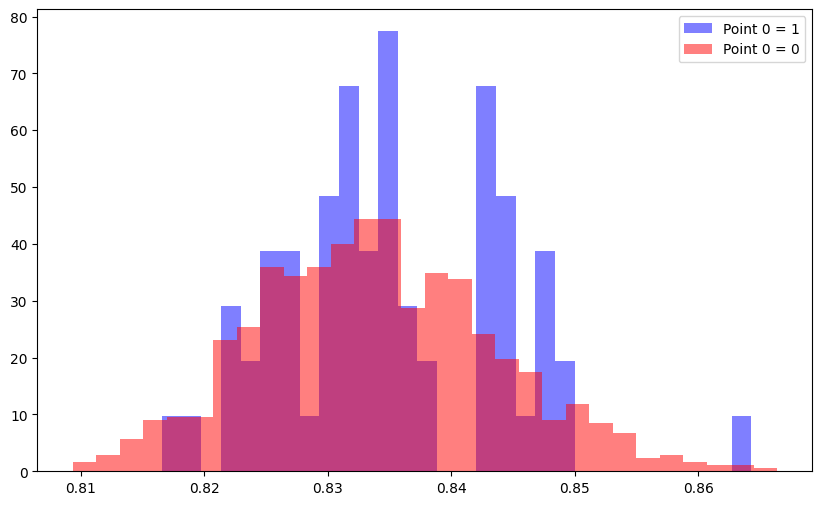

In [16]:
# Initialize a plot
fig, ax = plt.subplots(figsize=(10, 6))

# Get indices of vectors where the current point is 1
indices_1 = np.where(data['slices'][0][:, point] == 1)[0]

# Get the values in the 'distinguishability' for the indices where the point is 1
values_1 = [data['distinguishability'][i]['average']['prediction_auc_rescaled'] for i in indices_1]

# Get indices of vectors where the current point is 0
indices_0 = np.where(data['slices'][0][:, point] == 0)[0]

# Get the values in the 'distinguishability' for the indices where the point is 0
values_0 = [data['distinguishability'][i]['average']['prediction_auc_rescaled'] for i in indices_0]

# Plot the distributions (histogram) for both sets of values
ax.hist(values_1, bins=30, density=True, alpha=0.5, label=f'Point {point} = 1', color='blue')
ax.hist(values_0, bins=30, density=True, alpha=0.5, label=f'Point {point} = 0', color='red')
ax.legend()


In [17]:
# Initialize lists to store results
mean_auc_1 = []
mean_auc_0 = []
difference = []
p_values = []

# Loop through each of the 200 points
for point in range(200):
    # Get indices where the current point is 1 and 0
    indices_1 = np.where(data['slices'][0][:, point] == 1)[0]
    indices_0 = np.where(data['slices'][0][:, point] == 0)[0]
    
    # Calculate means (handle cases where no 1s or 0s exist for safety)
    mean_1 = np.mean([data['distinguishability'][i]['average']['propensity_mse'] for i in indices_1]) if len(indices_1) > 0 else np.nan
    mean_0 = np.mean([data['distinguishability'][i]['average']['propensity_mse'] for i in indices_0]) if len(indices_0) > 0 else np.nan

    # Get the values in the 'distinguishability' for the indices where the point is 1
    values_1 = [data['distinguishability'][i]['average']['prediction_auc_rescaled'] for i in indices_1]
    values_0 = [data['distinguishability'][i]['average']['prediction_auc_rescaled'] for i in indices_0]
    
    # Append to lists
    mean_auc_1.append(mean_1)
    mean_auc_0.append(mean_0)
    difference.append(mean_1 - mean_0)

    # Perform a one-sided t-test: H0: mean(values_1) >= mean(values_0), H1: mean(values_1) < mean(values_0)
    if len(values_1) > 1 and len(values_0) > 1:  # Need at least 2 values to perform a t-test
        t_stat, p_value = stats.ttest_ind(values_1, values_0, alternative='less')
    else:
        p_value = np.nan  # Not enough data for a valid test
    
    p_values.append(p_value)

# Create a DataFrame
df = pd.DataFrame({
    'Point': np.arange(200),
    'propensity_mse (1)': mean_auc_1,
    'propensity_mse (0)': mean_auc_0,
    'Difference': difference,
    'p_value': p_values,
    'True label': challenge_labels['is_train']
})

In [21]:
df.sort_values('p_value', ascending=True).head(50)['True label'].mean()

0.5

In [23]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Step 1: Standardize the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(challenge[['trans_date', 'trans_type', 'operation',
       'amount', 'balance', 'k_symbol', 'bank', 'account']])
synth_test_scaled = scaler.transform(synth_test)

# Step 2: Apply K-Means clustering
kmeans = KMeans(n_clusters=20, random_state=42, n_init=10)
clusters = kmeans.fit_predict(df_scaled)
synth_clusters = kmeans.predict(synth_test_scaled)

In [24]:
no_id_cols = ['trans_date', 'trans_type', 'operation', 'amount', 'balance',
       'k_symbol', 'bank', 'account']

In [25]:
from typing import Union, List, Tuple, Type
def propensity_mse(propensity_scores: Union[List[float], np.ndarray]) -> float:
    """
    Compute the mean squared error between 0.5 (classifier cannot distinguish between real and synthetic data)
    and the predicted probabilities.

    :param propensity_scores: the predicted probabilities of being a real record
    :return: the propensity mean squared error
    """
    n = len(propensity_scores)
    pi = np.array(propensity_scores)

    pmse = 1 / n * np.sum((pi - 0.5) ** 2) / 0.25

    return pmse

In [26]:
# Initialize list to store the differences
point_differences = []
mean_propensity_1 = []
mean_propensity_0 = []

# Loop through each point
for point in range(200):
    # Get the cluster for this point
    point_cluster = clusters[point]
    
    # Get indices of synth_test samples belonging to this cluster
    cluster_indices = np.where(synth_clusters == point_cluster)[0]
    
    # Get indices where the binary vectors have 1 and 0 at this point
    indices_1 = np.where(data['slices'][0][:, point] == 1)[0]
    indices_0 = np.where(data['slices'][0][:, point] == 0)[0]
    
    # Get predictions for each slice from prediction_per_point
    mse_1 = []
    mse_0 = []
    
    for idx in indices_1:
        predictions = data['distinguishability'][idx]['detailed']['prediction_real_split']
        mse_1.append(np.mean([propensity_mse(run[cluster_indices]) for run in predictions]))
    
    for idx in indices_0:
        predictions = data['distinguishability'][idx]['detailed']['prediction_real_split']
        mse_0.append(np.mean([propensity_mse(run[cluster_indices]) for run in predictions]))
    
    # Calculate the difference between the two prediction averages
    mean_mse_1 = np.mean(mse_1) if len(mse_1) > 0 else np.nan
    mean_mse_0 = np.mean(mse_0) if len(mse_0) > 0 else np.nan
    diff = mean_mse_1 - mean_mse_0 if not (np.isnan(mean_mse_1) or np.isnan(mean_mse_0)) else np.nan
    
    mean_propensity_1.append(mean_mse_1)
    mean_propensity_0.append(mean_mse_0)
    point_differences.append(diff)

# Create a DataFrame with the differences
results_df = pd.DataFrame({
    'Point': np.arange(200),
    'Mean propensity 1': mean_propensity_1,
    'Mean propensity 0': mean_propensity_0,
    'Propensity Difference': point_differences,
    'Label': challenge_labels['is_train'],
    'Cluster': clusters,
})

In [27]:
results_df.groupby('Cluster')['Propensity Difference'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
0,3.0,-0.001090,0.001561,-0.002175,-0.001985,-0.001795,-0.000548,0.000699
1,22.0,0.000741,0.002358,-0.003312,-0.000457,0.000601,0.001775,0.006748
2,11.0,-0.000982,0.002043,-0.004415,-0.002638,0.000017,0.000400,0.001617
3,12.0,0.000024,0.003262,-0.006044,-0.001806,0.000071,0.002040,0.006193
4,7.0,-0.000668,0.002179,-0.003773,-0.002170,-0.000675,0.000925,0.002262
5,10.0,0.000035,0.002553,-0.003688,-0.001916,0.000684,0.001982,0.003329
6,15.0,0.000436,0.000699,-0.000757,0.000158,0.000404,0.000739,0.001808
7,12.0,-0.000152,0.002313,-0.004442,-0.001367,0.000418,0.001273,0.003774
8,25.0,-0.001098,0.003879,-0.010612,-0.003056,-0.001844,0.000975,0.008177


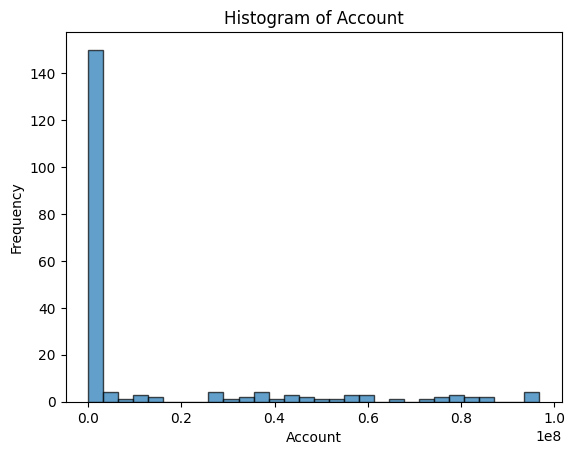

In [28]:
# Plot histogram
plt.hist(challenge['account'], bins=30, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Account")
plt.ylabel("Frequency")
plt.title("Histogram of Account")

# Show the plot
plt.show()

In [30]:
results_df.sort_values('Propensity Difference', ascending=True).head(100)['Label'].mean()

0.44

# Do it by 10 nearest neighbors

In [31]:
from scipy.spatial import distance

In [32]:
# Initialize lists to store the differences
point_differences = []

# Loop through each point (column in synth_test and slices)
for point in range(200):
    # Get the feature vector of the observation point from the challenge dataframe
    observation_point = challenge[no_id_cols].iloc[point].values.reshape(1, -1)

    # Calculate distances from the observation point to all points in synth_test
    dist_matrix = distance.cdist(observation_point, synth_test[no_id_cols], 'euclidean')

    # Get indices of the 10 nearest neighbors in synth_test to the observation point
    nearest_neighbors = np.argsort(dist_matrix, axis=1)[:, :500].flatten()
    # Get indices where the binary vectors have 1 and 0 at this point
    indices_1 = np.where(data['slices'][0][:, point] == 1)[0]
    indices_0 = np.where(data['slices'][0][:, point] == 0)[0]

    # Get the predictions for each slice from prediction_per_point
    pred_1 = []
    pred_0 = []

    for idx in indices_1:
        predictions = np.mean(data['distinguishability'][idx]['detailed']['prediction_real_split'], axis=0)  # Mean over 10 runs
        pred_1.extend(predictions[nearest_neighbors])

    for idx in indices_0:
        predictions = np.mean(data['distinguishability'][idx]['detailed']['prediction_real_split'], axis=0)  # Mean over 10 runs
        pred_0.extend(predictions[nearest_neighbors])

    # Calculate the difference between the two prediction averages
    mean_1 = np.mean(pred_1) if len(pred_1) > 0 else np.nan
    mean_0 = np.mean(pred_0) if len(pred_0) > 0 else np.nan
    diff = mean_1 - mean_0 if not (np.isnan(mean_1) or np.isnan(mean_0)) else np.nan

    point_differences.append(diff)

# Create a DataFrame with the differences
results_df = pd.DataFrame({
    'Point': np.arange(200),
    'Prediction Difference': point_differences
})


In [33]:
results_df['labels']=challenge_labels

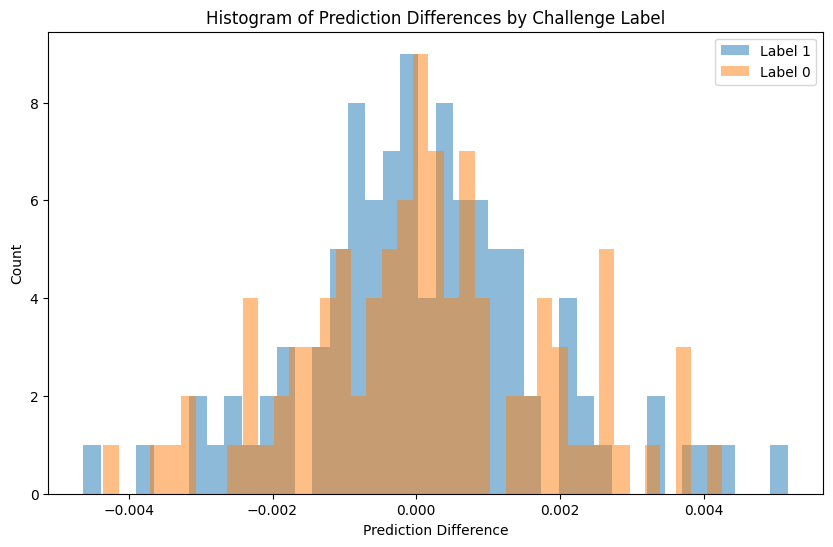

In [34]:
# Plot histogram of prediction differences for each label
plt.figure(figsize=(10, 6))
plt.hist(results_df[results_df['labels'] == 1]['Prediction Difference'], bins=40, alpha=0.5, label='Label 1')
plt.hist(results_df[results_df['labels'] == 0]['Prediction Difference'], bins=40, alpha=0.5, label='Label 0')
plt.xlabel('Prediction Difference')
plt.ylabel('Count')
plt.legend()
plt.title('Histogram of Prediction Differences by Challenge Label')
plt.show()

In [39]:
results_df.sort_values('Prediction Difference', ascending=True).head(100)['labels'].mean()

0.53

# Try with only account <> 0

In [40]:
account_clusters = np.where(challenge['account']!=0, 1, 0)
synth_account_clusters = np.where(synth_test['account']!=0, 1, 0)

In [41]:
# Initialize list to store the differences
point_differences = []
mean_propensity_1 = []
mean_propensity_0 = []

# Loop through each point
for point in range(200):
    # Get the cluster for this point
    point_cluster = account_clusters[point]
    
    # Get indices of synth_test samples belonging to this cluster
    cluster_indices = np.where(synth_account_clusters == point_cluster)[0]
    
    # Get indices where the binary vectors have 1 and 0 at this point
    indices_1 = np.where(data['slices'][0][:, point] == 1)[0]
    indices_0 = np.where(data['slices'][0][:, point] == 0)[0]
    
    # Get predictions for each slice from prediction_per_point
    mse_1 = []
    mse_0 = []
    
    for idx in indices_1:
        predictions = data['distinguishability'][idx]['detailed']['prediction_real_split']
        mse_1.append(np.mean([propensity_mse(run[cluster_indices]) for run in predictions]))
    
    for idx in indices_0:
        predictions = data['distinguishability'][idx]['detailed']['prediction_real_split']
        mse_0.append(np.mean([propensity_mse(run[cluster_indices]) for run in predictions]))
    
    # Calculate the difference between the two prediction averages
    mean_mse_1 = np.mean(mse_1) if len(mse_1) > 0 else np.nan
    mean_mse_0 = np.mean(mse_0) if len(mse_0) > 0 else np.nan
    diff = mean_mse_1 - mean_mse_0 if not (np.isnan(mean_mse_1) or np.isnan(mean_mse_0)) else np.nan
    
    mean_propensity_1.append(mean_mse_1)
    mean_propensity_0.append(mean_mse_0)
    point_differences.append(diff)

# Create a DataFrame with the differences
results_df = pd.DataFrame({
    'Point': np.arange(200),
    'Mean propensity 1': mean_propensity_1,
    'Mean propensity 0': mean_propensity_0,
    'Propensity Difference': point_differences,
    'Label': challenge_labels['is_train'],
    'Cluster': account_clusters,
})

In [42]:
challenge[challenge_labels['is_train']==1]

,trans_id,account_id,trans_date,trans_type,operation,amount,balance,k_symbol,bank,account
1,2286684,7542,1870,0,3,10609.0,43078.5,1,0,0
5,212579,721,732,2,4,540.0,23700.8,1,0,0
6,130507,437,396,2,4,11100.0,37398.1,1,0,0
7,2968984,9833,799,2,1,6531.0,68645.6,5,10,35473787
9,569417,1938,985,2,1,6646.0,62512.4,5,5,28358316
...,...,...,...,...,...,...,...,...,...,...
194,1118357,3820,1157,0,3,5200.0,40136.4,1,0,0
195,116527,393,1771,2,1,5920.0,22398.1,0,1,27135431
196,860740,2932,1410,2,1,7.0,84595.8,0,9,33505654
197,2908142,9633,1420,0,3,34246.0,73085.1,1,0,0
